In [1]:
from google.cloud import bigquery
import os
import pprint
from google.oauth2 import service_account
from pandas.io import gbq
import json
import pandas as pd
import matplotlib.pyplot as plt

local_google_credentials = '/home/vincent/Lambo-89cff3bde0ba.json'

try:
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = local_google_credentials
    client = bigquery.Client()
except:
    client = bigquery.Client()
    

In [2]:
def bqtopd(query):
    return gbq.read_gbq(query, "lambo-192519")

In [3]:
coinlist_location = "utils/coinlist.json"
with open(coinlist_location) as coinlist_r:
    coinlist = json.load(coinlist_r)
coinlist_df = pd.DataFrame.from_dict(coinlist, orient='index')
coinlist_df['CMC_rank']=coinlist_df['CMC_rank'].astype(str).astype(int)

In [107]:
top20 = coinlist_df[coinlist_df['CMC_rank'] < 8]['CMC_ID'].tolist()
top20 = tuple(top20)
print(top20)

('bitcoin-cash', 'bitcoin', 'eos', 'ethereum', 'litecoin', 'stellar', 'ripple')


In [108]:
query = """
            SELECT CMC_ID, CMC_ticker, Timestamp, CC_BTC_PRICE, CC_USD_PRICE, CC_ETH_PRICE
            FROM Market_Fetch.raw_prices
            WHERE CMC_ID IN {0} AND Timestamp > '2018-05-01 00:00:00' AND Timestamp < '2018-06-01 00:00:00'; 
        """.format(top20)
%time df = bqtopd(query)
df.shape

CPU times: user 5.27 s, sys: 290 ms, total: 5.56 s
Wall time: 20.3 s


(62503, 6)

In [109]:
df["CC_USD_NORM"]=(df["CC_USD_PRICE"]-df["CC_USD_PRICE"].min())/(df["CC_USD_PRICE"].max()-df["CC_USD_PRICE"].min())

In [110]:
df.head()

,CMC_ID,CMC_ticker,Timestamp,CC_BTC_PRICE,CC_USD_PRICE,CC_ETH_PRICE,CC_USD_NORM
0,bitcoin-cash,BCH,2018-05-25 04:55:30,0.1391,1053.51,1.74,0.105751
1,bitcoin-cash,BCH,2018-05-25 04:45:42,0.1394,1056.95,1.74,0.106096
2,bitcoin-cash,BCH,2018-05-25 05:05:30,0.1394,1058.87,1.75,0.106289
3,bitcoin-cash,BCH,2018-05-25 05:10:31,0.1396,1060.86,1.74,0.106489
4,bitcoin-cash,BCH,2018-05-25 04:50:40,0.1394,1056.12,1.75,0.106013


In [116]:
df = df.sort_values('Timestamp')
df['usd_pct'] = testdf.groupby('CMC_ID')['CC_USD_PRICE'].apply(lambda x:x.pct_change())

In [117]:
df.head()

,CMC_ID,CMC_ticker,Timestamp,CC_BTC_PRICE,CC_USD_PRICE,CC_ETH_PRICE,CC_USD_NORM,usd_pct,usd_pct_norm
27662,ethereum,ETH,2018-05-01 00:00:30,0.072450,670.3600,1.00000,0.067281,0.000000,0.016232
20691,eos,EOS,2018-05-01 00:00:30,0.001891,17.4600,0.02605,0.001728,-0.050785,0.015394
48569,ripple,XRP,2018-05-01 00:00:38,0.000090,0.8303,0.00124,0.000059,0.000000,0.016232
13720,bitcoin-cash,BCH,2018-05-01 00:00:38,0.145900,1346.6000,2.01000,0.135178,0.000185,0.016235
34627,litecoin,LTC,2018-05-01 00:00:38,0.016040,148.1700,0.22130,0.014852,0.003937,0.016297


In [118]:
df = df[abs(df.usd_pct)<0.25] #remove weird outlier values
(df.loc[df['usd_pct']>1].sort_values('Timestamp'))

,CMC_ID,CMC_ticker,Timestamp,CC_BTC_PRICE,CC_USD_PRICE,CC_ETH_PRICE,CC_USD_NORM,usd_pct,usd_pct_norm


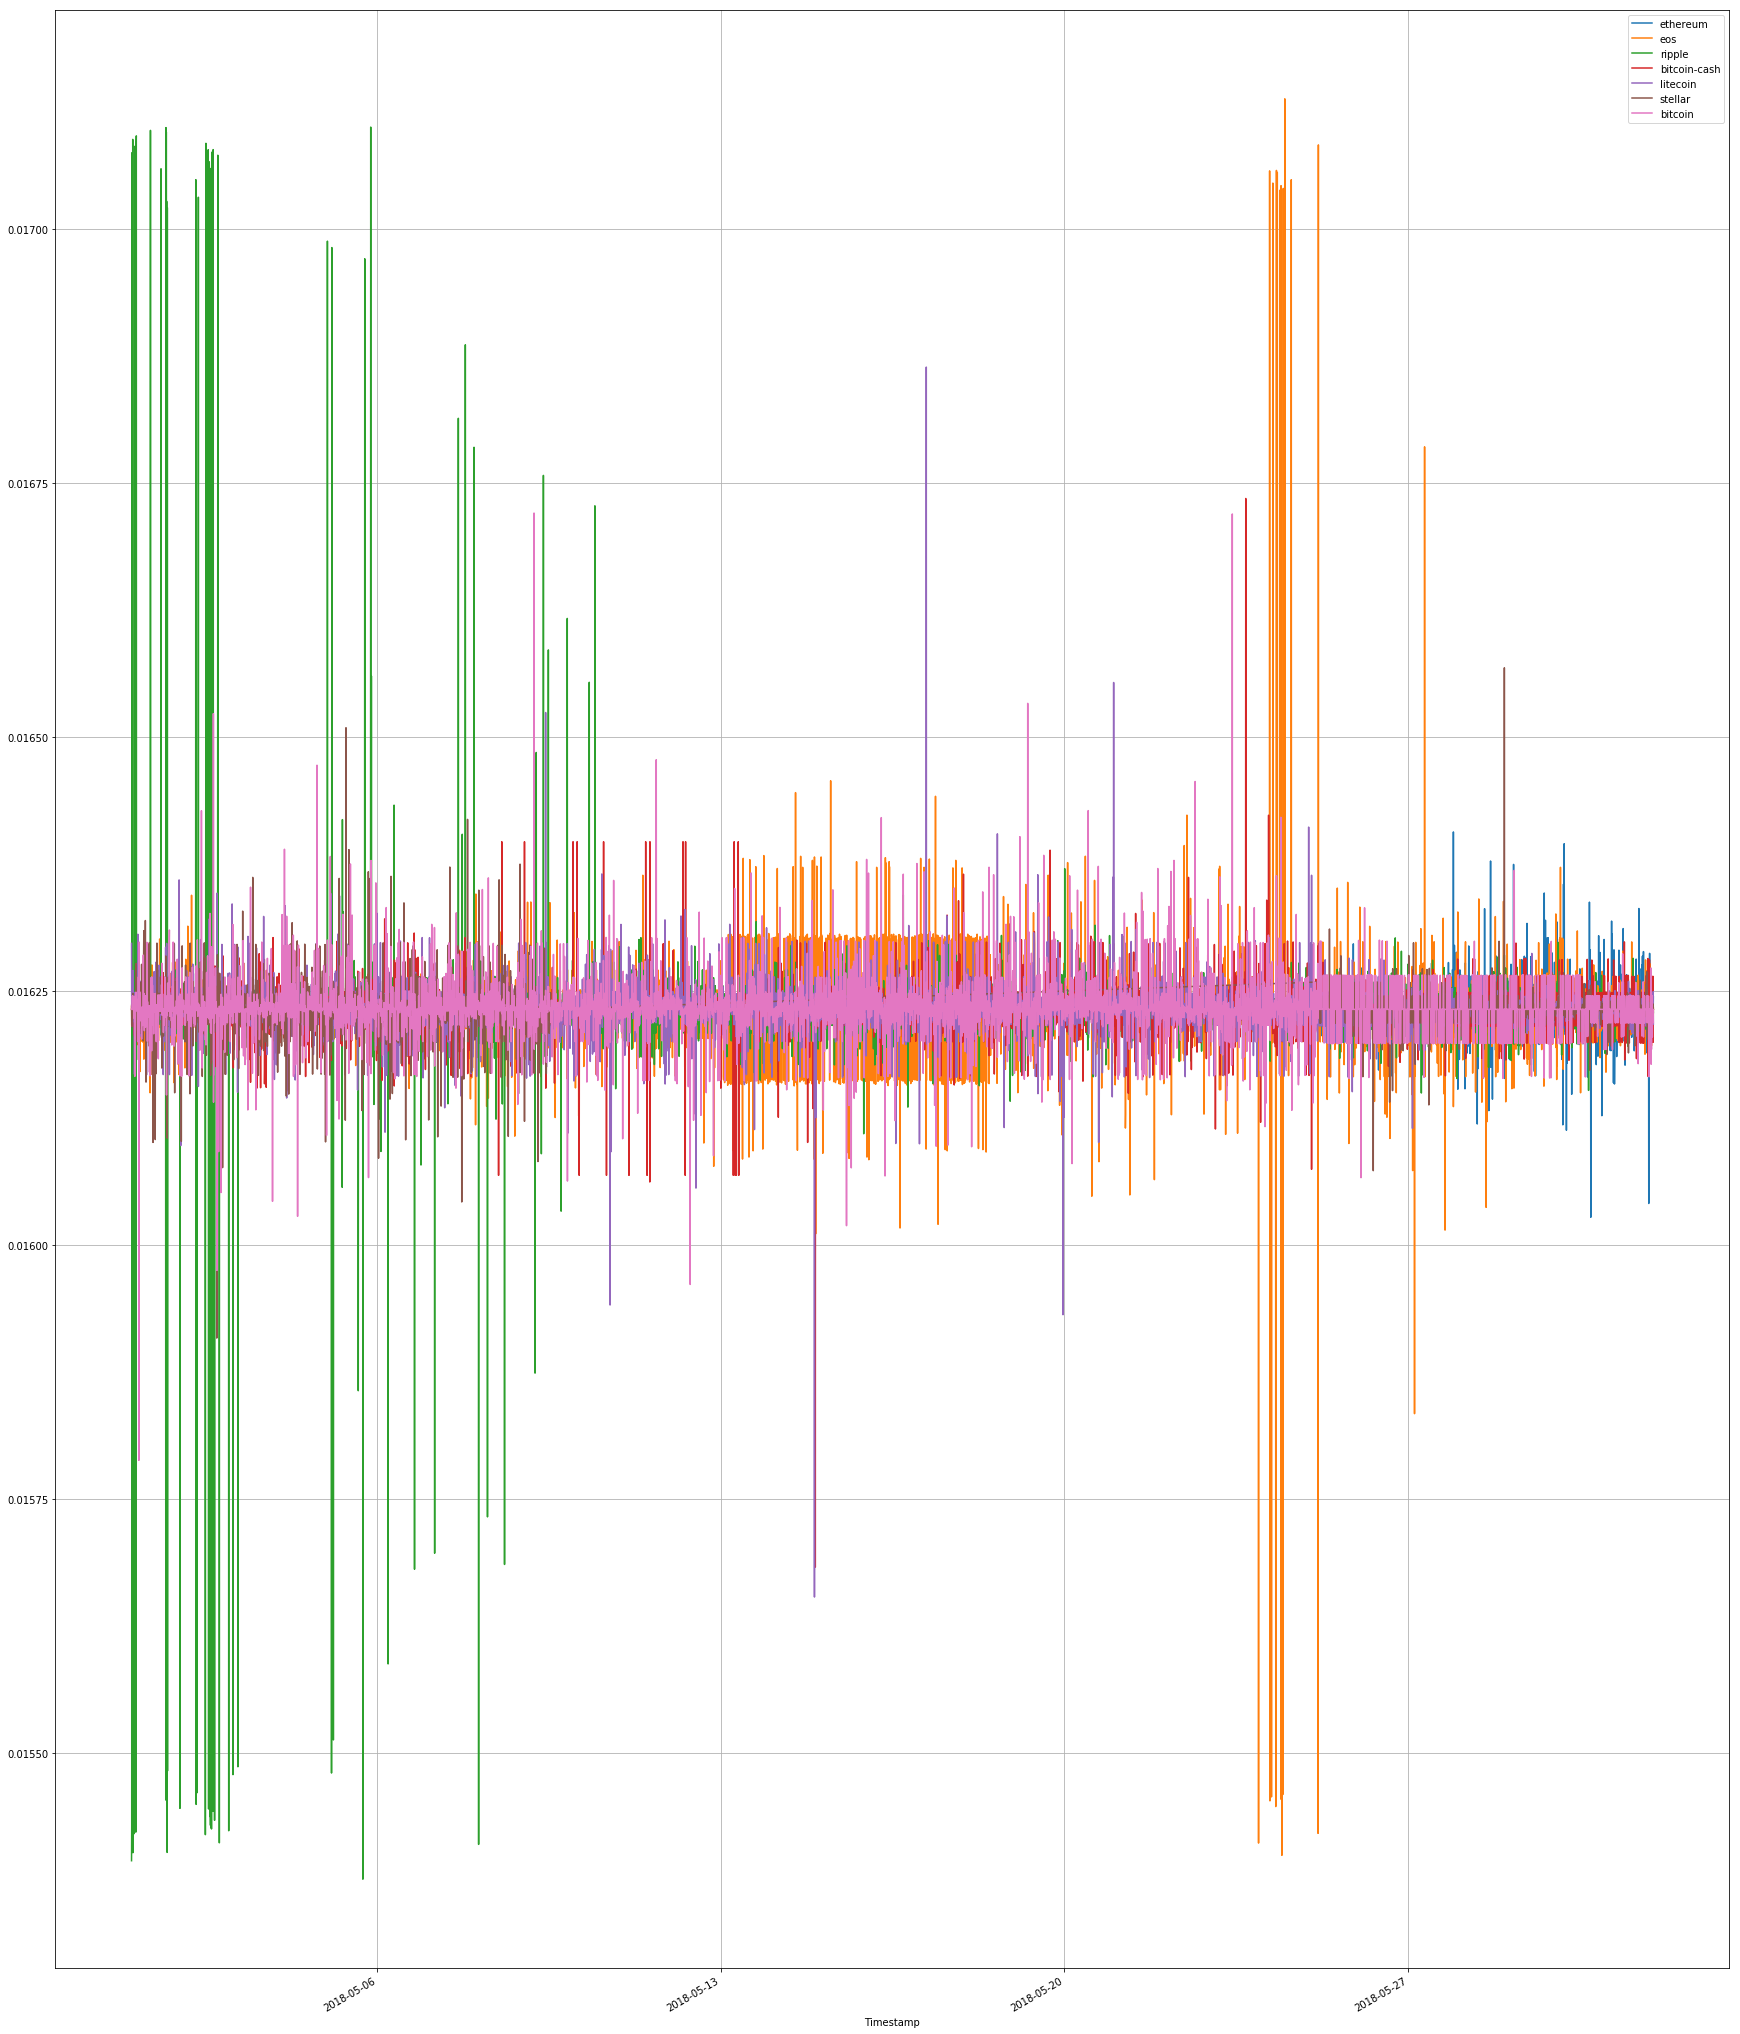

In [119]:
fig, ax = plt.subplots()
fig.set_size_inches(30, 40)
names = df.CMC_ID.unique()
df.reset_index().groupby('CMC_ID').plot(x='Timestamp', y='usd_pct_norm', ax=ax)
plt.legend(names)
plt.grid()
plt.show()